# Data Analysis and Machine Learning Applications for Physicists

*Material for a* [*University of Illinois*](http://illinois.edu) *course offered by the* [*Physics Department*](https://physics.illinois.edu). *This content is maintained on* [*GitHub*](https://github.com/illinois-mla) *and is distributed under a* [*BSD3 license*](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
from mls import locate_data

In [3]:
a_data = pd.read_hdf(locate_data('cluster_a_data.hf5'))
b_data = pd.read_hdf(locate_data('cluster_b_data.hf5'))
c_data = pd.read_hdf(locate_data('cluster_c_data.hf5'))
d_data = pd.read_hdf(locate_data('cluster_d_data.hf5'))

In [4]:
cluster_3d = pd.read_hdf(locate_data('cluster_3d_data.hf5'))

In [5]:
cosmo_data = pd.read_hdf(locate_data('cosmo_data.hf5'))

## SciKit Learn

This will be our first time using the [SciKit Learn package](http://scikit-learn.org/stable/).  We don't include it in our standard preamble since it contains many modules (sub-packages).  Instead, we import each module as we need it.  The ones we need now are:

In [6]:
from sklearn import preprocessing, cluster

## Find Structure in Data

The type of structure we can look for is "clusters" of "nearby" samples, but the definition of these terms requires some care.

### Distance between samples

In the simplest case, all features $x_{ij}$ have the same (possibly dimensionless) units, and the natural distance between samples (rows) $j$ and $k$ is:

$$ \Large
d(j, k) = \sum_{\text{features}\,i} (x_{ji} - x_{ki})^2 \; .
$$

However, what if some columns have different units?  For example, what is the distance between:

$$ \Large
\left( 1.2, 0.4~\text{cm}, 5.2~\text{kPa}\right)
$$

and

$$ \Large
\left( 0.7, 0.5~\text{cm}, 4.9~\text{kPa}\right)
$$

?

ML algorithms are generally unit-agnostic, so will happily combine features with different units but that may not be what you really want.

### Whitening transformation

One reasonable solution is to normalize each feature with the [whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation):

$$ \Large
x \rightarrow (x - \mu) / \sigma
$$

where $\mu$, $\sigma$ are the mean and standard deviation of the original feature values.

It is called "whitening" because it transforms the input vector into a [white noise vector](https://en.wikipedia.org/wiki/White_noise)
![WN1](img/Clustering/440px-White_noise.png)
![WN2](img/Clustering/White-noise-mv255-240x180.png)

Generally speaking, a whitening transformation is a linear transformation that transforms a vector of random variables with a known covariance matrix into a set of new variables whose covariance is the identity matrix, meaning that they are uncorrelated and each have unit variance. 

Suppose that $X$ is a column vector of random data with a non-singular covariance matrix $M$. Then the transformation 

$$ \Large
Y = WX
$$

with a whitening matrix $W$ satisfying the condition

$$ \Large
W^T W = M^{-1}
$$

yields the whitened random vector $Y$ with unit diagonal convariance. There are an infinite nunber of possible whitening matrices that satisfy the condition above. One common choice is via the Principle Component Analyis (PCA) method which utilizes the eigen-system of $M$ to whiten $X$. We will come back to this in a bit when we talk more about dimensionality reduction. 

### Why whiten the inputs?

In general, learning algorithms benefit from standardization of the data set to minimize differences in the mean and variance of the input features. If some outliers are present in the set, robust scalers or transformers are more appropriate. We will learn more about this when we talk about the PCA method, but you can read [Importance of Feature Scaling](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py) if you want to read more now.

The [sklearn.preprocessing module](http://scikit-learn.org/stable/modules/preprocessing.html) automates this process with:

In [7]:
cosmo_data.describe()

,omega_b,omega_cdm,ln10^{10}A_s,H0
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.022252,0.119777,3.094768,67.284306
std,0.000923,0.008673,0.196490,3.833436
min,0.020650,0.104801,2.754002,60.670622
25%,0.021460,0.112233,2.924718,63.934918
50%,0.022250,0.119758,3.093983,67.305942
75%,0.023048,0.127305,3.265802,70.633425
max,0.023850,0.134800,3.433990,73.869231


In [8]:
cosmo_normed = cosmo_data.copy()
cosmo_normed[cosmo_data.columns] = preprocessing.scale(cosmo_data)

In [9]:
cosmo_normed.describe()

,omega_b,omega_cdm,ln10^{10}A_s,H0
count,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04
mean,7.516839e-14,-2.716021e-14,2.182998e-13,7.600072e-14
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-1.735789e+00,-1.726691e+00,-1.734287e+00,-1.725280e+00
25%,-8.584267e-01,-8.697915e-01,-8.654500e-01,-8.737388e-01
50%,-1.958299e-03,-2.131438e-03,-3.995583e-03,5.644049e-03
75%,8.617981e-01,8.679544e-01,8.704566e-01,8.736686e-01
max,1.731191e+00,1.732135e+00,1.726426e+00,1.717778e+00


However, this may discard useful information contained in the relative normalization between features. To normalize only certain columns use, for example:

In [10]:
cosmo_normed = cosmo_data.copy()
for colname in 'ln10^{10}A_s', 'H0':
    cosmo_normed[colname] = preprocessing.scale(cosmo_data[colname])

## What is a "cluster"?

In the simplest case (a), clusters are well separated by a line (in 2D, or hyperplane in more dimensions) and can be unambiguously identified by looking only at the distance between pairs of samples.

In practice, clusters might overlap leading to ambiguities (b), or the clusters we expect to find might require considering groups of more than two samples at a time (c), or might have a non-linear separation boundary (d).
![Cluster Types](img/Clustering/cluster_types.png)

## Examples of Clustering in Physics

The ability to cluster data from physics instruments is critical to being able to extract important features from the data on the road to making inference about nature. 

### Physics at the LHC

There are many examples of data clustering in the study of particle collisions at the LHC. One important exampe is the clustering of data from calorimeter detectors to find the remants of quark or gluon production -- called "jets". A jet is a narrow cone of hadrons and other particles produced by the hadronization of a quark or gluon in a particle physics or heavy ion experiment. Particles carrying a color charge, such as quarks, cannot exist in free form because of QCD confinement which only allows for colorless states.

![](img/Clustering/ATLAS_event_display_vp1_run266904_evt25855182_2015-06-03T13-41-48_b.png)

![](img/Clustering/2jets.jpg)

### Astronomy

Astrophysical objects have a variety of distinct objects and emissions that reflect the richness and beauty of our Universe. So, its not surprising that clustering algorthims to identify and ultimately understand astrophysical objects play a central role in Astronomy. 

As an example, astronomers use properties of Gamma Ray Bursts (GRBs) such as their location in the sky, arrival time, duration, fluence, spectral hardness to find subtypes/classes of events:

![](img/Clustering/GRBs.png)

![](img/Clustering/times.png)


## K-means Clustering

The [K-means algorithm](https://en.wikipedia.org/wiki/K-means_clustering) is fast and robust, but assumes that your data consists of roughly round clusters of the same size (where the meanings of "round" and "size" depend on how your data is scaled).

Most sklearn algorithms use a similar calling pattern:
```
result = module.ClassName(..args..).fit(data)
```
For the [KMeans algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans):

In [11]:
a_fit = cluster.KMeans(n_clusters=2).fit(a_data)

We will use the following function to display 2D cluster results (don't worry about the [details](https://seaborn.pydata.org/tutorial/color_palettes.html) unless you are interested):

In [12]:
def display(data, fit):
    n_clusters = len(np.unique(fit.labels_))
    # Pick good colors to distinguish the different clusters.
    import matplotlib.colors
    cmap = matplotlib.colors.ListedColormap(
        sns.color_palette("husl", n_clusters).as_hex())
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], s=10, c=fit.labels_, cmap=cmap)
    # Use standard axes to match the plot above.
    plt.xlim(-9, +9)
    plt.ylim(-5, +5)
    plt.gca().set_aspect(1.)

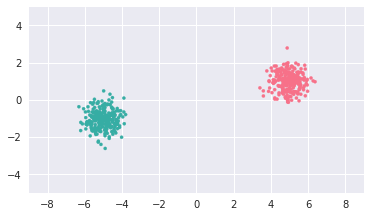

In [13]:
display(a_data, a_fit)

**EXERCISE:** Use KMeans to fit the three other (b,c,d) 2D datasets with `n_clusters=2` and generate similar plots. Which fits give the expected results?

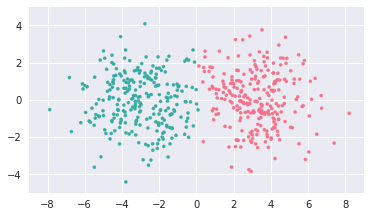

In [14]:
b_fit = cluster.KMeans(n_clusters=2).fit(b_data)
display(b_data, b_fit)

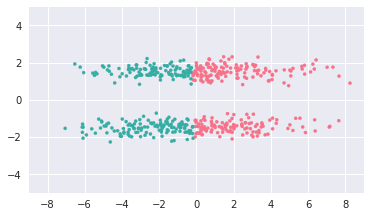

In [15]:
c_fit = cluster.KMeans(n_clusters=2).fit(c_data)
display(c_data, c_fit)

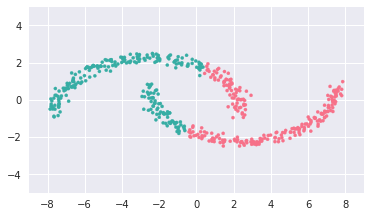

In [16]:
d_fit = cluster.KMeans(n_clusters=2).fit(d_data)
display(d_data, d_fit)

The fit results look reasonable for (b), although the sharp dividing line between the two clusters looks artificial.

The fit results for (c) and (d) do not match what we expect because KMeans only considers one pair at a time, so cannot identify larger scale patterns that are obvious by eye.

In [17]:
# Add your solution here...

### Hyperparameters

Algorithms have many parameters that influence their results for a given dataset, but these fall into two categories:
- Parameters whose values are determined by the data during the fitting process.
- Parameters which must be externally set.

We refer the second group as "hyperparameters" and set their values during the "model selection" process, which we will discuss later.

**DISCUSS:** Are all of the arguments of the [KMeans constructor](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) hyperparameters?

In principle, yes, but in practice some of these arguments will have no (or minimal) impact on the algorithm result under normal conditions.  The arguments that are most clearly hyperparameters are:
- `n_clusters`, `algorithm`, `tol`

The arguments that are most clearly not hyperparameters are:
- `verbose`, `precompute_distances`, `n_jobs`

The remaining arugments are in the gray area.  In general, it is prudent to experiment with your actual data to identify which arguments affect your results significantly.

**EXERCISE:** Fit dataset (b) with the `n_clusters` hyperparameter set to 3 and display the results. Comparing with the 2-cluster fit above, by eye, what do think is the "true" number of clusters?  How might you decide between 2 and 3 more objectively?

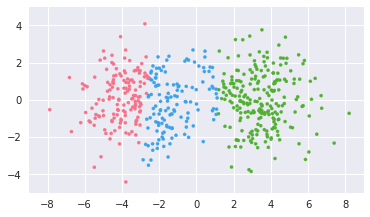

In [18]:
b_fit_3 = cluster.KMeans(n_clusters=3).fit(b_data)
display(b_data, b_fit_3)

The plot above makes a convincing case (to me, at least) that there are three clusters.  However, the "truth" in this case is two clusters.

This illustrates the dangers of superimposing a fit result on your data: it inevitably "draws your eye" and makes the fit more credible. Look out for examples of this when reading papers or listening to talks!

In [19]:
# Add your solution here...

### Clustering in many dimensions

An algorithm to find clusters in 2D data is just automating what you could already by eye.  However, most clustering algorithms also work well with higher dimensional data, where the clusters might not be visible in any single 2D projection.

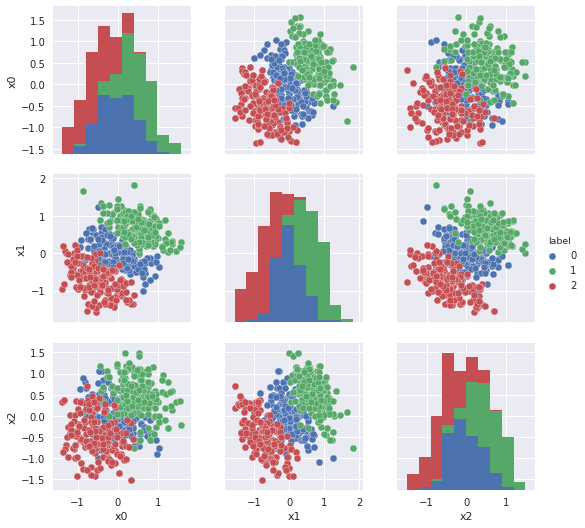

In [20]:
fit_3d = cluster.KMeans(n_clusters=3).fit(cluster_3d)
cluster_3d['label'] = fit_3d.labels_
sns.pairplot(cluster_3d, vars=('x0', 'x1', 'x2'), hue='label');

These clusters look quite arbitrary in each of the 2D scatter plots. However, they are actually very well separated, as we can see if we rotate the axes:

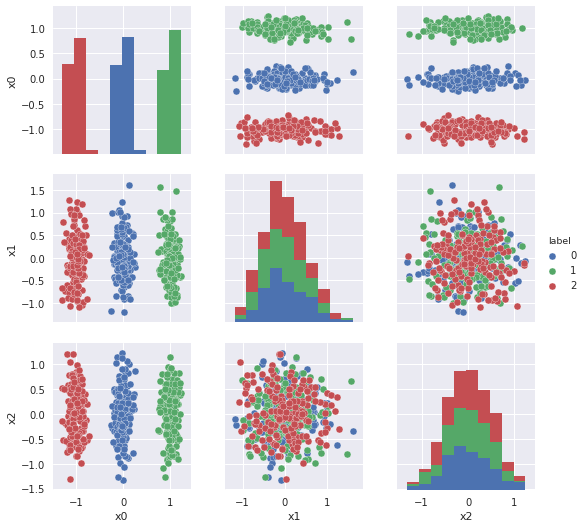

In [21]:
R = np.array(
    [[ 0.5  , -0.5  , -0.707],
     [ 0.707,  0.707,  0.   ],
     [ 0.5  , -0.5  ,  0.707]])
rotated_3d = cluster_3d.copy()
rotated_3d[['x0', 'x1', 'x2']] = cluster_3d[['x0', 'x1', 'x2']].dot(R)
sns.pairplot(rotated_3d, vars=('x0', 'x1', 'x2'), hue='label');

This example is contrived, but the lesson is that clustering algorithms can discover higher-dimensional structure that you might miss with visualization.

## General comments on ML Algorithms

Now that we have introduced our first ML algorithm, this is a good time for some general comments.

Most ML algorithms have some common features:
- They seek to maximize (or minimize) some goal function $f(\theta, D)$ of the (fixed) data $D$, for some (unknown) parameters $\theta$.
- The goal function embodies some model (perhaps only implicitly) of what the data is expected to look like.

Questions to ask about the goal function:
- Is there a single global optimum by construction? (i.e., is $\pm f$ a [convex function](https://en.wikipedia.org/wiki/Convex_function)?)
- If not, might there be multiple local optima?

Questions to ask about how the algorithm optimizes its goal function:
- Is it exact or approximate?
- If it is approximate, is it also iterative?  If so, what are the convergence criteria?
- How does the running time scale with the number of samples and number of features?

The goal function of the KMeans algorithm is:

$$ \Large
\sum_{i=1}^n\, \sum_{c_j = i}\, \left| x_j - \mu_i\right|^2
$$

where $c_j = 1$ if sample $j$ is assigned to cluster $i$ or otherwise $c_j = 0$, and

$$ \Large
\mu_i = \sum_{c_j = i}\, x_j
$$

is the mean of samples assigned to cluster $i$.  The outer sum is over the number of clusters $n$ and $j$ indexes samples. If we consider sample $x_j$ to be a vector, then its elements are the feature values.

**DISCUSS:** What are the parameters of the KMeans goal function?  How many parameters are there?

The parameters are the binary values $c_j$ and there is one per sample (row). Note that the number of parameters is independent of the number of features (columns) in the data.

The number of clusters $n$ is a hyperparameter since it is externally set and not adjusted by the algorithm in response to the data.

The means $\mu_i$ are not independent parameters since their values are fixed by the $c_j$ (given the data).

### Supervised vs Unsupervised

ML algorithms come in two flavors, depending on whether they require some training data where you already know the answer ("supervised") or not ("unsupervised"). Clustering algorithms are unsupervised.

An advantage of unsupervised ML is that it works with any input data, and can discover patterns that you might not already know about (as in the 3D example above).  Even when you have training data available, an unsupervised algorithm can still be useful.

The disadvantage of unsupervised learning is that we cannot formulate objective measures for how well an algorithm is performing, so the results are always somewhat subjective.

## Expectation Maximization

The KMeans algorithm uses an iterative solution based on the [Expectation-Maximization (EM)](https://en.wikipedia.org/wiki/Expectation-maximization_algorithm) principle. This is a powerful approach used by many algorithms, which we will revist several times during the course.

## Other Clustering Methods

We have focused on KMeans as a prototypical clustering algorithm, but there are [many others to chose from](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html).

We will finish this section with some brief experimentation with two alternatives that use more global information than KMeans, so are better suited to examples (c) and (d) above:
- Spectral clustering: [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html), [wikipedia](https://en.wikipedia.org/wiki/Spectral_clustering).
- Density-based spatial clustering of applications with noise (DBSCAN): [sklearn](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering), [wikipedia](https://en.wikipedia.org/wiki/DBSCAN).

**EXERCISE:** Use `cluster.SpectralClustering` to fit `c_data` and `d_data` and display the results.  Adjust the default hyperparameters, if necessary, to obtain the expected results.

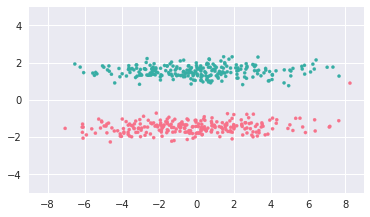

In [22]:
c_fit = cluster.SpectralClustering(n_clusters=2).fit(c_data)
display(c_data, c_fit)

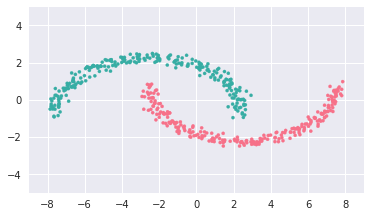

In [23]:
d_fit = cluster.SpectralClustering(n_clusters=2, gamma=2.0).fit(d_data)
display(d_data, d_fit)

In [24]:
# Add your solution here...

**EXERCISE:** Use `cluster.DBSCAN` to fit `c_data` and `d_data` and display the results.  Adjust the default hyperparameters, if necessary, to obtain the expected results.

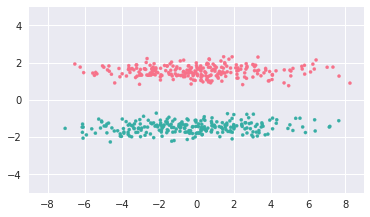

In [25]:
c_fit = cluster.DBSCAN(eps=1.5).fit(c_data)
display(c_data, c_fit)

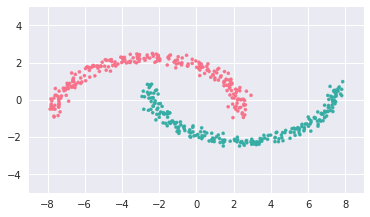

In [26]:
d_fit = cluster.DBSCAN().fit(d_data)
display(d_data, d_fit)

In [27]:
# Add your solution here...